## **Preprocessing**

### **Importing Libararies**

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

import xgboost as xgb
import lightgbm as lgb

from statsmodels.tsa.seasonal import seasonal_decompose

import gradio as gr

### **Data Loading**

In [23]:
train_path = '/kaggle/input/walmart-sales-forecast/train.csv'
df = pd.read_csv(train_path)
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [24]:
df['Date'] = pd.to_datetime(df['Date'])

In [25]:
df = df.sort_values(['Store','Dept','Date']).reset_index(drop=True)

In [26]:
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['weekofyear'] = df['Date'].dt.isocalendar().week.astype(int)
df['dayofweek'] = df['Date'].dt.dayofweek
df['day'] = df['Date'].dt.day

print(df.head())

   Store  Dept       Date  Weekly_Sales  IsHoliday  year  month  weekofyear  \
0      1     1 2010-02-05      24924.50      False  2010      2           5   
1      1     1 2010-02-12      46039.49       True  2010      2           6   
2      1     1 2010-02-19      41595.55      False  2010      2           7   
3      1     1 2010-02-26      19403.54      False  2010      2           8   
4      1     1 2010-03-05      21827.90      False  2010      3           9   

   dayofweek  day  
0          4    5  
1          4   12  
2          4   19  
3          4   26  
4          4    5  


### **Lag & rolling features**

In [28]:
def create_lags_rollings(df, group_cols=['Store','Dept'], target_col='Weekly_Sales',
                         lags=[1,2,3,4], roll_windows=[4,12]):
    out = df.copy()
    
    # Lag features
    for lag in lags:
        out[f'lag_{lag}'] = out.groupby(group_cols)[target_col].shift(lag)
    
    # Rolling features
    for w in roll_windows:
        out[f'roll_mean_{w}'] = (
            out.groupby(group_cols)[target_col]
            .transform(lambda x: x.shift(1).rolling(window=w, min_periods=1).mean())
        )
        out[f'roll_std_{w}'] = (
            out.groupby(group_cols)[target_col]
            .transform(lambda x: x.shift(1).rolling(window=w, min_periods=1).std())
        )
    
    return out

# apply
df_feats = create_lags_rollings(df, group_cols=['Store','Dept'])
df_feats = df_feats.dropna().reset_index(drop=True)

print("Features shape:", df_feats.shape)
print(df_feats.head())

Features shape: (408436, 18)
   Store  Dept       Date  Weekly_Sales  IsHoliday  year  month  weekofyear  \
0      1     1 2010-03-05      21827.90      False  2010      3           9   
1      1     1 2010-03-12      21043.39      False  2010      3          10   
2      1     1 2010-03-19      22136.64      False  2010      3          11   
3      1     1 2010-03-26      26229.21      False  2010      3          12   
4      1     1 2010-04-02      57258.43      False  2010      4          13   

   dayofweek  day     lag_1     lag_2     lag_3     lag_4  roll_mean_4  \
0          4    5  19403.54  41595.55  46039.49  24924.50   32990.7700   
1          4   12  21827.90  19403.54  41595.55  46039.49   32216.6200   
2          4   19  21043.39  21827.90  19403.54  41595.55   25967.5950   
3          4   26  22136.64  21043.39  21827.90  19403.54   21102.8675   
4          4    2  26229.21  22136.64  21043.39  21827.90   22809.2850   

     roll_std_4  roll_mean_12   roll_std_12  
0  12

### **Seasonal Decomposition**

Series length = 143 weeks


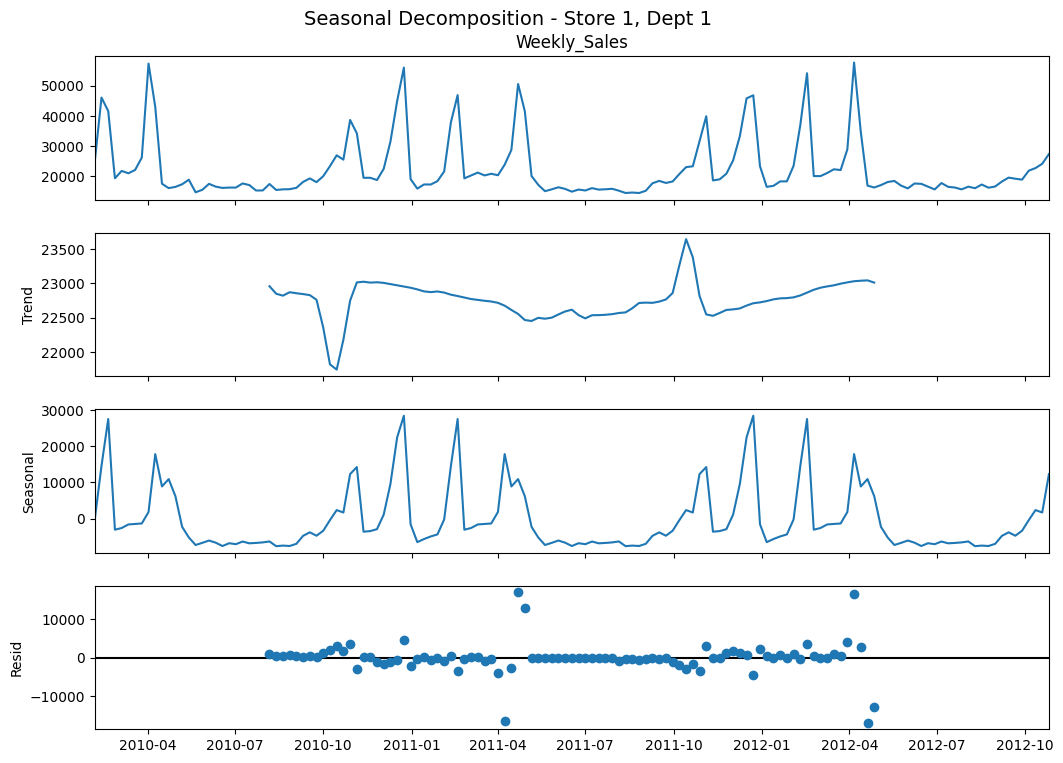

In [29]:
s, d = 1, 1
subset = df[(df['Store']==s) & (df['Dept']==d)].set_index('Date')['Weekly_Sales']

# Find dominant weekday
dominant_day = pd.Series(subset.index.day_name()).mode()[0]
weekday_map = {
    "Monday": "W-MON","Tuesday": "W-TUE","Wednesday": "W-WED",
    "Thursday": "W-THU","Friday": "W-FRI","Saturday": "W-SAT","Sunday": "W-SUN"
}
freq = weekday_map[dominant_day]

# Reindex to weekly
series = subset.asfreq(freq).fillna(method='ffill').fillna(method='bfill').dropna()

print(f"Series length = {len(series)} weeks")

if len(series) >= 104:
    res = seasonal_decompose(series, model='additive', period=52)
    fig = res.plot()
    fig.set_size_inches(12, 8)
    plt.suptitle(f'Seasonal Decomposition - Store {s}, Dept {d}', fontsize=14)
    plt.show()
else:
    print(f"Not enough data for decomposition (need 104 weeks, got {len(series)})")

### **Train/Test split**

In [30]:
# Pick one store-dept for modeling
s, d = 1, 1
data = df_feats[(df_feats['Store']==s) & (df_feats['Dept']==d)].copy()

In [31]:
data = data.sort_values('Date')

In [32]:
# Train/test split
train = data[data['Date'] < "2012-01-01"]
test = data[data['Date'] >= "2012-01-01"]

features = [c for c in data.columns if c not in ['Weekly_Sales','Date']]

X_train, y_train = train[features], train['Weekly_Sales']
X_test, y_test = test[features], test['Weekly_Sales']

## **Models**

### **Baseline Linear Regression**

Linear Regression RMSE: 9407.818133978833


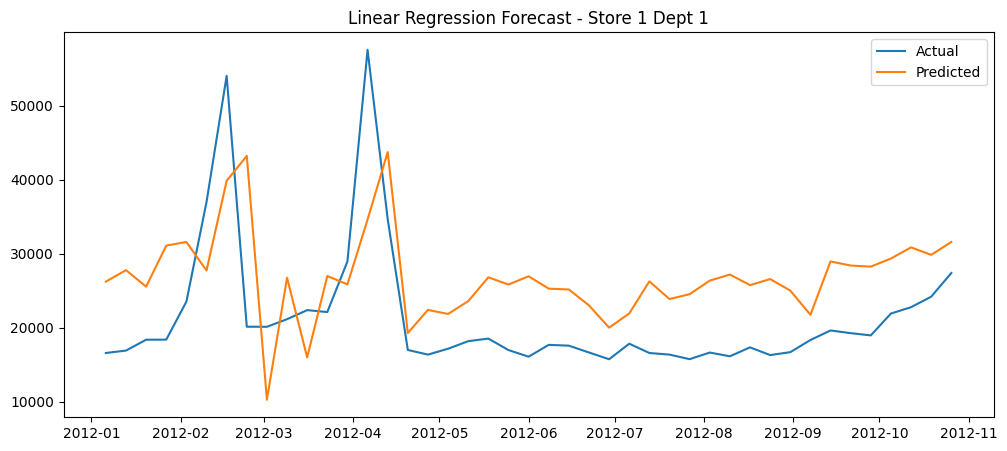

In [33]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
print("Linear Regression RMSE:", rmse_lr)

plt.figure(figsize=(12,5))
plt.plot(test['Date'], y_test, label='Actual')
plt.plot(test['Date'], y_pred_lr, label='Predicted')
plt.legend()
plt.title("Linear Regression Forecast - Store 1 Dept 1")
plt.show()

### **XGBoost Model**

XGBoost RMSE: 3356.785873360651


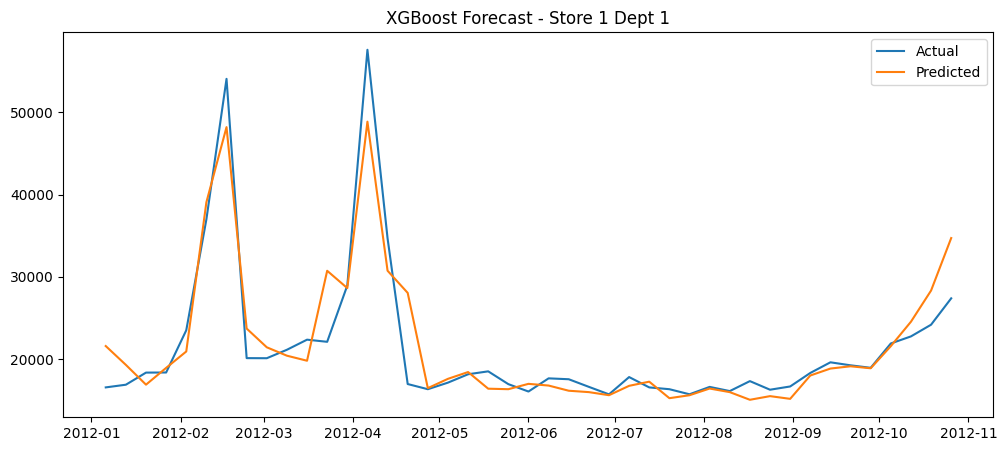

In [34]:
xgb_model = xgb.XGBRegressor(
    n_estimators=300, learning_rate=0.1, max_depth=5, subsample=0.8, colsample_bytree=0.8
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
print("XGBoost RMSE:", rmse_xgb)

plt.figure(figsize=(12,5))
plt.plot(test['Date'], y_test, label='Actual')
plt.plot(test['Date'], y_pred_xgb, label='Predicted')
plt.legend()
plt.title("XGBoost Forecast - Store 1 Dept 1")
plt.show()

### **LightGBM Model**

In [36]:
import lightgbm as lgb

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Train with callbacks
lgb_model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_eval],
    num_boost_round=500,
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

y_pred_lgb = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[310]	valid_0's rmse: 5113.15


## **Simple Interface**

In [ ]:
import gradio as gr
import pandas as pd
import xgboost as xgb

def forecast_next(store, dept, date_str):
    date = pd.to_datetime(date_str)
    data = df_feats[(df_feats['Store']==store) & (df_feats['Dept']==dept)].copy()
    data = data.sort_values('Date')
    features = [c for c in data.columns if c not in ['Weekly_Sales','Date']]
    
    # train on all history
    X, y = data[features], data['Weekly_Sales']
    model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=5)
    model.fit(X, y)
    
    # latest row as base
    latest = data[data['Date']==data['Date'].max()][features]
    pred = model.predict(latest)[0]
    return f"Predicted Weekly Sales for Store {store}, Dept {dept}: {pred:,.2f}"

iface = gr.Interface(
    fn=forecast_next,
    inputs=[
        gr.Number(label="Store ID"), 
        gr.Number(label="Dept ID"), 
        gr.Textbox(label="Date (YYYY-MM-DD)")
    ],
    outputs="text",
    title="📊 Walmart Sales Forecasting Tool",
    description="Enter Store ID, Department ID, and Date to forecast the next week's sales using an XGBoost regression model."
)

iface.launch(debug=True)


* Running on local URL:  http://127.0.0.1:7860
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://35b1aa8b809cedd914.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
